In [1]:
usage = """Run with papermill:
     
papermill BQSR_report.ipynb output_BQSR_report.ipynb \
    -p report_name <> \
    -p model_file <> \
    -p X_file <> \
    -p y_file <> \
    -p single_sub_regions \
    -p params_file <>

Then convert to html

jupyter nbconvert --to html output_BQSR_report.ipynb --template classic --no-input --output BQSR_report.html"""

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import sys
from IPython.display import Image, HTML
import joblib
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
import seaborn as sns
from os.path import basename, dirname, join as pjoin

from scipy.interpolate import interp1d
from scipy.stats import binom, pearsonr
from os.path import isfile, join as pjoin
for path in [pjoin('/data1', "proj/VariantCalling"), "/VariantCalling"]:
    if os.path.isdir(path) and path not in sys.path:
        sys.path.insert(1, path)

from ugvc.utils.metrics_utils import read_effective_coverage_from_sorter_json
from ugvc.srsnv.srsnv_utils import precision_score_with_mask, recall_score_with_mask, precision_recall_curve, plot_precision_recall


pd.options.display.max_rows = 200

In [3]:
# papermill parameters
report_name = None
model_file = None
X_file = None
y_file = None
params_file = None

In [4]:
# check that we got all the inputs
missing = list()
for varname in [
    "report_name",
    "model_file",
    "X_file",
    "y_file",
    "params_file",
]:
    if locals()[varname] is None:
        missing.append(varname)

if len(missing) > 0:
    raise ValueError(f"Following inputs missing:\n{(os.linesep).join(missing)}")

ValueError: Following inputs missing:
report_name
model_file
X_file
y_file
params_file

In [2]:
report_name = "test"
model_file = "/data1/work/rinas/xgbpipeline/balanced_ePCR_LA5_LA6_333_bLaDt_06.model.joblib"
X_file = "/data1/work/rinas/xgbpipeline/balanced_ePCR_LA5_LA6_333_bLaDt_06.X_test.parquet"
y_file = "/data1/work/rinas/xgbpipeline/balanced_ePCR_LA5_LA6_333_bLaDt_06.y_test.parquet"
single_sub_regions = '/data1/cloud_sync/gs/concordanz/hg38/UG-High-Confidence-Regions/v1.3/ug_hcr.bed'
params_file = "/data1/work/rinas/xgbpipeline/balanced_ePCR_LA5_LA6_333_bLaDt_06.params.json"

In [3]:
# load model, data and params
xgb_classifier = joblib.load(model_file)
X_test = pd.read_parquet(X_file)
y_test = pd.read_parquet(y_file)
params = None
with open(params_file, 'r') as f:
    params = json.load(f)

In [ ]:
# papermill parameters
h5_substitution_error_rate = None
png_substitution_error_rate_by_mut_type_and_source = None

In [ ]:
Image(png_substitution_error_rate_by_mut_type_and_source, width=1000)

In [8]:
display(HTML(f'<font size="6">BQSR training report - {report_name}</font>'))

# Introduction 

This report contains an analysis of the BQSR model training. The model is xgboost NN, trained as binary classifier per read. The probabilities are translated to quality: quality = -10*log10(probability). The quality is later used for discrimination between true and false variants in mrd analysis.

In [5]:
print('\nData:')
print(params['data_name'])


Data:
balanced_ePCR_LA5_LA6_333_LuNgs_08


In [4]:
def inference_on_dataframe(xgb_classifier,X,y):
    cls_features = xgb_classifier.feature_names_in_
    probs = xgb_classifier.predict_proba(X[cls_features])
    predictions = xgb_classifier.predict(X[cls_features])
    quals = -10*np.log10(1-probs)
    # labels = np.unique(y["label"])        
    predictions_df = pd.DataFrame(y)            
    labels = np.unique(y["label"].astype(int))
    for label in labels:
        predictions_df[f'XGB_prob_{label}'] = probs[:, label]
        predictions_df[f'XGB_qual_{label}'] = quals[:,label]
        predictions_df[f'XGB_prediction_{label}'] = predictions[:,label]
    df = pd.concat([X, predictions_df.drop(['label'],axis='columns',inplace=False)], axis=1)

    df_tp = df.query(f"label == True")
    df_fp = df.query(f"label == False")

    fprs = {}
    recalls = {}
    max_score = -1
    for label in labels:
        fprs[label] = []
        recalls[label] = []
        score = f'XGB_qual_{label}'
        max_score = np.max((int(np.ceil(df[score].max())), max_score))
        gtr = df['label'] == label
        fprs_, recalls_ = precision_recall_curve(df[score], max_score=max_score, y_true=gtr)
        fprs[label].append(fprs_)
        recalls[label].append(recalls_)


    return df, df_tp, df_fp, labels, max_score, cls_features, fprs, recalls

df, df_tp, df_fp, labels, max_score, cls_features, fprs, recalls = inference_on_dataframe(xgb_classifier,X_test,y_test)
labels_dict = {0: "FP", 1: "TP"}


# AUC curve

In [11]:
params.keys()

dict_keys(['hom_snv_featuremap', 'single_substitution_featuremap', 'hom_snv_regions', 'single_sub_regions', 'cram_stats_file', 'workdir', 'out_basename', 'reference_fasta', 'flow_order', 'model_params', 'data_name', 'model_save_path', 'X_test_save_path', 'y_test_save_path', 'X_train_save_path', 'y_train_save_path', 'params_save_path', 'f_fp_training', 'f_tp_training'])

In [14]:
params['data_name']

'balanced_ePCR_LA5_LA6_333_LuNgs_08'

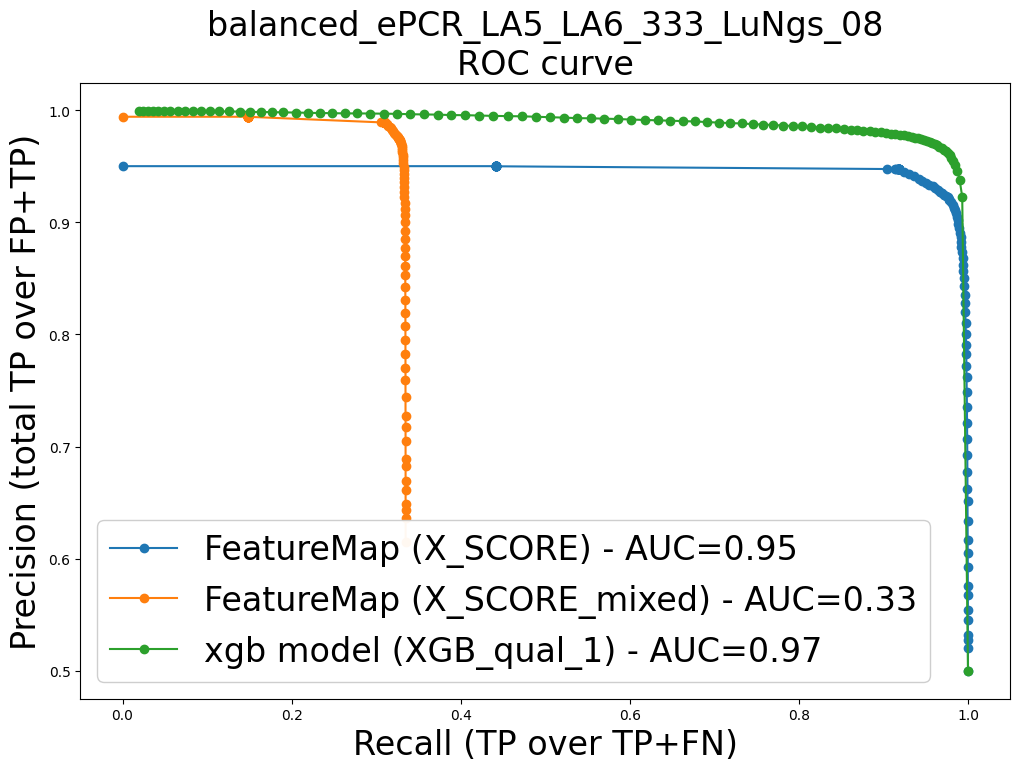

In [5]:
def plot_ROC_curve(
        df: pd.DataFrame,
        df_tp: pd.DataFrame,
        df_fp: pd.DataFrame,        
        score: str = "",
        title: str = "",
        output_filename: str = None
        ):
    label_dict = {"X_SCORE": "FeatureMap", "X_SCORE_mixed": "FeatureMap", score: "xgb model"}

    recall = dict()
    precision = dict()
    for xvar,querystr,namestr in (("X_SCORE","X_SCORE>-1","X_SCORE"),("X_SCORE","is_mixed == True & X_SCORE>-1","X_SCORE_mixed"),(score,"X_SCORE>-1",score)):
        thresholds = np.linspace(0, df[xvar].quantile(0.99), 100)
        recall[namestr] = dict()
        precision[namestr] = dict()
        for thresh in thresholds:
            recall[namestr][thresh] = (df_tp.query(querystr)[xvar] > thresh).sum()/df_tp.shape[0] 
            total_fp = (df_fp.query(querystr)[xvar] >= thresh).sum()
            total_tp = (df_tp.query(querystr)[xvar] >= thresh).sum()
            precision[namestr][thresh] = total_tp / (total_tp + total_fp)


    # set_pyplot_defaults()
    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    for label in recall.keys():
        # plt.plot(recall[label].values(), precision[label].values(), "k")
        auc = -np.trapz(list(precision[label].values()), list(recall[label].values()))
        plt.plot(
            recall[label].values(),
            precision[label].values(),
            "-o",
            # c=list(precision[label].keys()),
            label=f"{label_dict[label]} ({label}) - AUC={auc:.2f}",
        )
        plt.xlabel("Recall (TP over TP+FN)",fontsize=24)
        plt.ylabel("Precision (total TP over FP+TP)",fontsize=24)
        legend_handle = plt.legend(fontsize=24, fancybox=True, framealpha=0.95)
        title_handle = plt.title(title, fontsize=24)


    if output_filename is not None:
        if not output_filename.endswith(".png"):
            output_filename += ".png"
        plt.savefig(
            output_filename,
            facecolor="w",
            dpi=300,
            bbox_inches="tight",
            bbox_extra_artists=[title_handle, legend_handle],
        )

output_roc_plot = os.path.join(params['workdir'], f"{params['out_basename']}ROC_curve")

plot_ROC_curve(df,df_tp,df_fp,score="XGB_qual_1",title=f"{params['data_name']}\nROC curve", output_filename=output_roc_plot)

## LoD

LoD estimation is defined with:

(residual_snv_rate) error rate = # errors / # bases sequenced 

where:

\# errors = # of single substitution snps > filter thresh

\# bases sequenced = bases aligned (cram) [= mean_coverage(Itai) * bases in region(from bed, Rina)]  * % mapq60(Itai) * % reads with coverage > min coverage((Itai) * read_filter_correction_factor 

\* downsampling factor [= % of the reads sampled] * recall(threshold)


In [19]:
import json
import pandas as pd

# load/define filters

edist_filter = "X_EDIST <= 5"
trim_ends = "X_INDEX > 12 and X_INDEX < (X_LENGTH - 12)"
filters_hueristic = {
    "no_filter": f"X_SCORE >= 0",
    "edit_distance_5": f"X_SCORE >= 0 and {edist_filter}",
    "BQ60": f"X_SCORE >= 6 and {edist_filter}",
    "BQ80": f"X_SCORE >= 7.9 and {edist_filter}",
    "CSKP": f"X_SCORE >= 10 and {edist_filter}",
    "BQ80_trim_ends": f"X_SCORE >= 7.9 and {edist_filter} and {trim_ends}",
    "CSKP_trim_ends": f"X_SCORE >= 10 and {edist_filter} and {trim_ends}",
    "BQ60_mixed_only": f"X_SCORE >= 6 and {edist_filter} and is_mixed",
    "BQ80_mixed_only": f"X_SCORE >= 7.9 and {edist_filter} and is_mixed",
    "CSKP_mixed_only": f"X_SCORE >= 10 and {edist_filter} and is_mixed",
    "BQ80_trim_ends_mixed_only": f"X_SCORE >= 7.9 and {edist_filter} and {trim_ends} and is_mixed",
    "CSKP_trim_ends_mixed_only": f"X_SCORE >= 10 and {edist_filter} and {trim_ends} and is_mixed",
}

xgb_filters = {
    f"xgb_qual_{q}": f"XGB_qual_1 >= {q}" for q in range(0, 29)
}

filters_dict = {
    **filters_hueristic,
    **xgb_filters,
}

with open('/data1/work/rinas/xgbpipeline/filters.json','w') as f:
    json.dump(filters_dict,f,indent=6)

In [28]:
def LoD_training_summary(single_sub_regions,cram_stats_file,sampling_rate,df,filters_file,df_summary_file,output_params_file):
    
    # apply filters to data
    with open(filters_file) as f:
        filters = json.load(f)

    df = df.assign(
        **{
            filter_name: df.eval(filter_query)
            for filter_name, filter_query in tqdm(filters.items())
            if filter_query is not None
        }
    )
    df_fp = df.query("label == 0")
    df_tp = df.query("label == 1")

    # count the # of bases in region
    n_bases_in_region = 0
    with open(single_sub_regions) as fh:
        for line in fh:
            if not line.startswith("@") and not line.startswith("#"):
                spl = line.rstrip().split("\t")
                n_bases_in_region += int(spl[2]) - int(spl[1])

    # get coverage statistics
    (mean_coverage,
    ratio_of_reads_over_mapq,
    ratio_of_bases_in_coverage_range,
    min_coverage_for_fp,
    coverage_of_max_percentile) = read_effective_coverage_from_sorter_json(cram_stats_file)

    read_filter_correction_factor = (df_tp["X_FILTERED_COUNT"]).sum() / df_tp["X_READ_COUNT"].sum()
    n_noise_reads = df_fp.shape[0]
    n_signal_reads = df_tp.shape[0]
    print('n_noise_reads, n_signal_reads', n_noise_reads, n_signal_reads)
    effective_bases_covered = mean_coverage * n_bases_in_region * sampling_rate * ratio_of_reads_over_mapq * ratio_of_bases_in_coverage_range * read_filter_correction_factor
    residual_snv_rate_no_filter = n_noise_reads / effective_bases_covered
    ratio_filtered_prior_to_featuremap = ratio_of_reads_over_mapq * read_filter_correction_factor

    df_summary = pd.concat(
        (
            (df_fp[list(filters.keys())].sum() / n_noise_reads).rename("FP"),
            (df_tp[list(filters.keys())].sum() / n_signal_reads * ratio_filtered_prior_to_featuremap).rename("TP"),
        ),
        axis=1,
    )

    df_summary = df_summary.assign(
        precision=df_summary["TP"] / (df_summary["FP"] + df_summary["TP"])
    )

    # save outputs    
    params_for_save = {
        'residual_snv_rate_no_filter': residual_snv_rate_no_filter
    }
    with open(output_params_file, "w", encoding="utf-8") as f:
        json.dump(params_for_save, f)

    df_summary.to_parquet(df_summary_file)

    return filters

def LoD_simulation_on_signature(LoD_params):

    df_summary = pd.read_parquet(LoD_params['df_summary_file'])

    with open(LoD_params['summary_params_file'], 'r') as f:
        summary_params = json.load(f)

    residual_snv_rate_no_filter = summary_params['residual_snv_rate_no_filter']

    sensitivity_at_lod = LoD_params['sensitivity_at_lod'] #0.90
    specificity_at_lod = LoD_params['specificity_at_lod'] #0.99

    # simulated LoD definitions and correction factors
    simulated_signature_size = LoD_params['simulated_signature_size'] #10_000
    simulated_coverage = LoD_params['simulated_coverage'] #30
    effective_signature_bases_covered = simulated_coverage * simulated_signature_size # * ratio_of_reads_over_mapq * read_filter_correction_factor

    df_mrd_sim = (df_summary[["TP"]]).rename(columns={"TP": "read_retention_ratio"})
    df_mrd_sim = df_mrd_sim.assign(
        residual_snv_rate=df_summary["FP"]
        * residual_snv_rate_no_filter
        / df_mrd_sim["read_retention_ratio"]
    )
    df_mrd_sim = df_mrd_sim.assign(
        min_reads_for_detection=np.ceil(
            binom.ppf(
                n=int(effective_signature_bases_covered),
                p=df_mrd_sim["read_retention_ratio"] * df_mrd_sim["residual_snv_rate"],
                q=specificity_at_lod,
            )
        )
        .clip(min=2)
        .astype(int),
    )

    tf_sim = np.logspace(-8, 0, 500)

    df_mrd_sim = df_mrd_sim.join(
        df_mrd_sim.apply(
            lambda row: tf_sim[
                np.argmax(
                    binom.ppf(
                        q=1 - sensitivity_at_lod,
                        n=int(effective_signature_bases_covered),
                        p=row["read_retention_ratio"] * (tf_sim + row["residual_snv_rate"]),
                    )
                    >= row["min_reads_for_detection"]
                )
            ],
            axis=1,
        ).rename(f"LoD_{sensitivity_at_lod*100:.0f}")
    )

    df_mrd_sim = df_mrd_sim[df_mrd_sim["read_retention_ratio"] > 0.01]
    lod_label = f"LoD @ {specificity_at_lod*100:.0f}% specificity, {sensitivity_at_lod*100:.0f}% sensitivity (estimated)\nsignature size {simulated_signature_size}, {simulated_coverage}x coverage"
    c_lod = f"LoD_{sensitivity_at_lod*100:.0f}"
    min_LoD_filter = df_mrd_sim['LoD_90'].idxmin()

    return df_mrd_sim, lod_label, c_lod, min_LoD_filter

cram_stats_file = params['cram_stats_file']
filters_file = '/data1/work/rinas/xgbpipeline/filters.json'
data_size = params['model_params'][f'{report_name}_size']
total_n = params['total_n_single_sub_featuremap']
sampling_rate = data_size/total_n # N reads in test (test_size) / N reads in single sub featuremap intersected with single_sub_regions

LoD_params = {}
LoD_params['df_summary_file'] = '/data1/work/rinas/xgbpipeline/df_summary.parquet'
LoD_params['summary_params_file'] = '/data1/work/rinas/xgbpipeline/summary_params.json'
LoD_params['sensitivity_at_lod'] = 0.90
LoD_params['specificity_at_lod'] = 0.99
LoD_params['simulated_signature_size'] = 10_000
LoD_params['simulated_coverage'] = 30

filters = LoD_training_summary(single_sub_regions,cram_stats_file,sampling_rate,df,filters_file, LoD_params['df_summary_file'], LoD_params['summary_params_file'])
df_mrd_sim, lod_label, c_lod, min_LoD_filter = LoD_simulation_on_signature(LoD_params)
print(min_LoD_filter)

100%|██████████| 41/41 [00:00<00:00, 48.46it/s]


n_noise_reads, n_signal_reads 150000 150000
xgb_qual_9


In [97]:
# df.memory_usage().sum() / 2**20

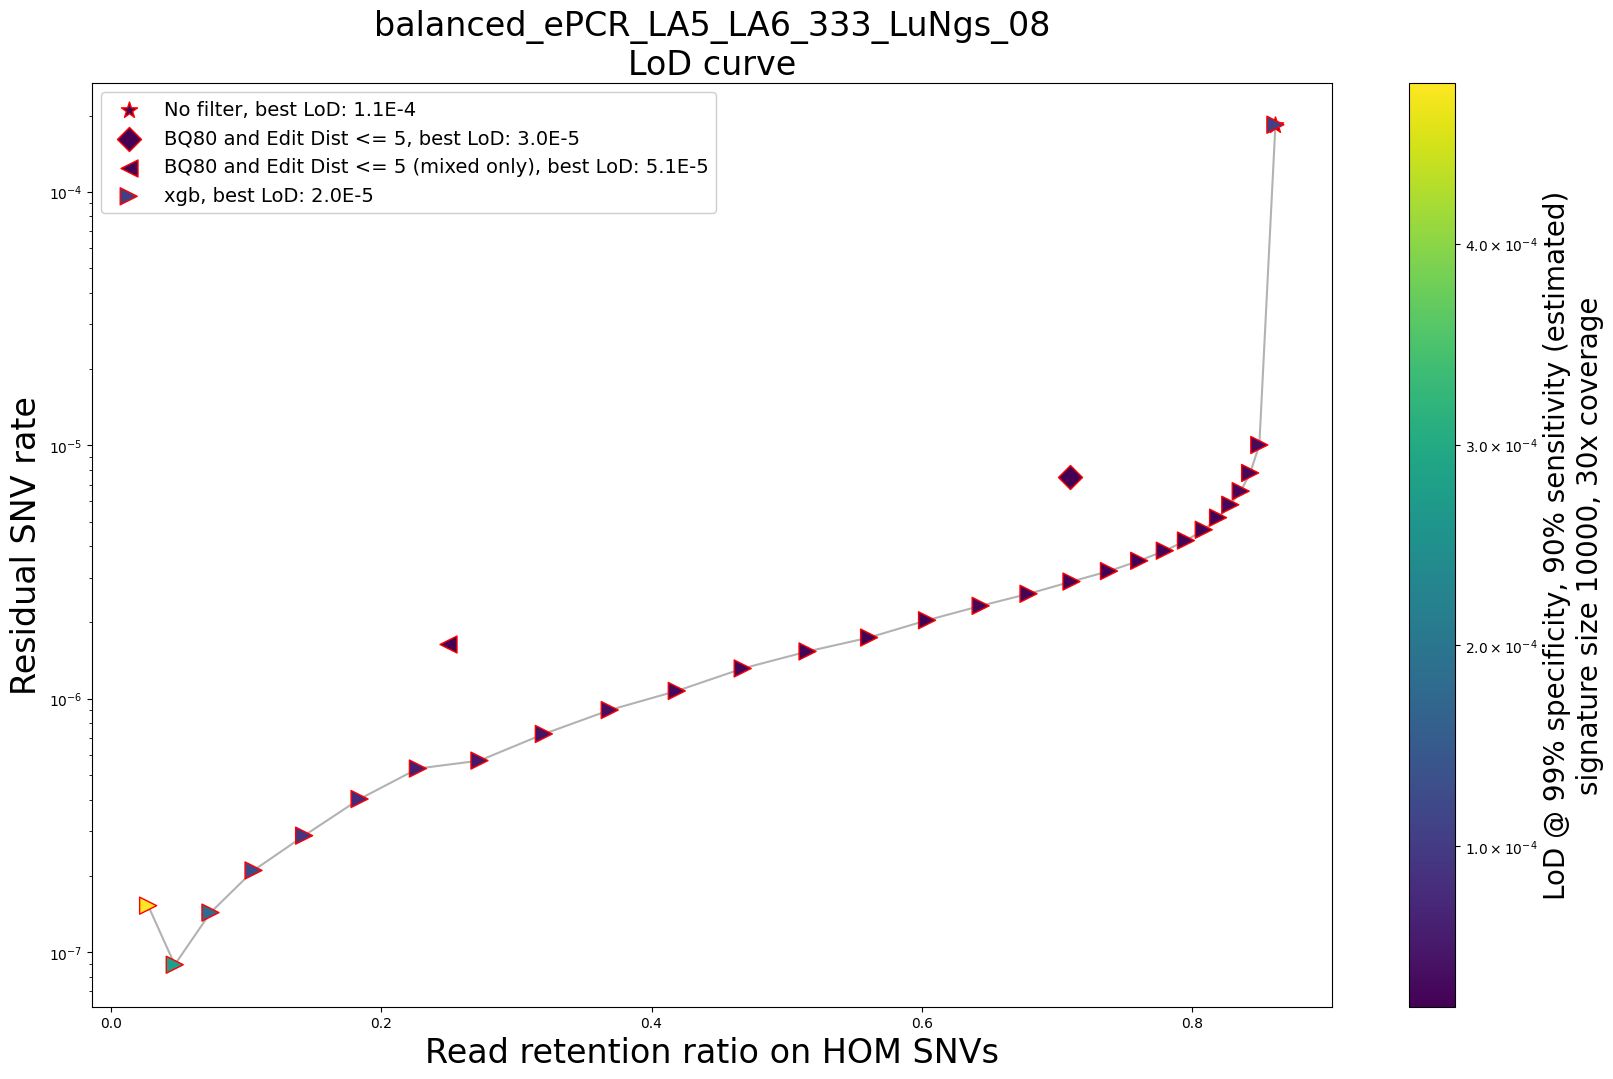

In [29]:
def plot_LoD(df_mrd_sim, lod_label, c_lod, filters, title ="", output_filename=""):
    
    xgb_filters = {i:filters[i] for i in filters if i[:3]=='xgb' and i in df_mrd_sim.index}
    
    plt.figure(figsize=(20, 12))

    for df_tmp, marker, label, edgecolor, markersize in zip(
        (
            df_mrd_sim.loc[["no_filter"]],
            df_mrd_sim.loc[["BQ80"]],
            df_mrd_sim.loc[["BQ80_mixed_only"]],
            df_mrd_sim.loc[list(xgb_filters)],
        ),
        (
            "*",
            "D",
            "<",
            ">",
            "s",
        ),
        (
            "No filter",
            "BQ80 and Edit Dist <= 5",
            "BQ80 and Edit Dist <= 5 (mixed only)",
            "xgb",
        ),
        ("r", "r", "r", "r", "none","none"),
        (150, 150, 150, 150, 100, 100),
    ):
        import matplotlib.colors as colors  # https://matplotlib.org/stable/tutorials/colors/colormapnorms.html

        plt.plot(
            df_tmp["read_retention_ratio"], df_tmp["residual_snv_rate"], c="k", alpha=0.3
        )
        best_lod = df_tmp[c_lod].min()
        mini, maxi = 7e-7, 2e-5  # or use different method to determine the minimum and maximum to use
        # norm = colors.PowerNorm(gamma=0.2,vmin=mini, vmax=maxi) #plt.Normalize(mini, maxi)
        sc = plt.scatter(
            df_tmp["read_retention_ratio"],
            df_tmp["residual_snv_rate"],
            c=df_tmp[c_lod],
            marker=marker,
            edgecolor=edgecolor,
            # cmap="viridis",
            label=label + ", best LoD: {:.1E}".format(best_lod).replace("E-0", "E-"),
            s=markersize,
            zorder=markersize,
            # norm=colors.PowerNorm(gamma=0.2,vmin=mini, vmax=maxi)
        )
        # sc.set_clim(mini,maxi)

    plt.xlabel("Read retention ratio on HOM SNVs", fontsize=24)
    plt.ylabel("Residual SNV rate", fontsize=24)
    plt.yscale("log")
    title_handle = plt.title(title, fontsize=24)
    legend_handle = plt.legend(fontsize=14, fancybox=True, framealpha=0.95)


    def fmt(x, pos):
        a, b = "{:.1e}".format(x).split("e")
        b = int(b)
        return r"${} \times 10^{{{}}}$".format(a, b)


    cb = plt.colorbar(format=ticker.FuncFormatter(fmt))
    cb.set_label(label=lod_label, fontsize=20)
    if output_filename is not None:
        if not output_filename.endswith(".png"):
            output_filename += ".png"
        plt.savefig(
            output_filename,
            facecolor="w",
            dpi=300,
            bbox_inches="tight",
            bbox_extra_artists=[title_handle, legend_handle],
        )

output_LoD_plot = os.path.join(params['workdir'], f"{params['out_basename']}LoD_curve")
plot_LoD(df_mrd_sim, lod_label, c_lod, filters,title=f"{params['data_name']}\nLoD curve", output_filename=output_LoD_plot)


# Training metrics

In [6]:
print(f"Forest size: {params['model_params']['forest_size']}")
print('\nLabels counts:')
print(y_test['label'].value_counts())
print('\nclassification report:')
print(classification_report(df['XGB_prediction_1'], y_test['label']))
print('\nprobabilities statistics:')
print(pd.DataFrame(df[['XGB_prob_0','XGB_prob_1']]).describe())



Forest size: 100

Labels counts:
False    150000
True     150000
Name: label, dtype: int64

classification report:


              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97    149266
         1.0       0.97      0.97      0.97    150734

    accuracy                           0.97    300000
   macro avg       0.97      0.97      0.97    300000
weighted avg       0.97      0.97      0.97    300000


probabilities statistics:
          XGB_prob_0     XGB_prob_1
count  300000.000000  300000.000000
mean        0.511434       0.488566
std         0.471388       0.471388
min         0.000464       0.000104
25%         0.016529       0.001492
50%         0.457943       0.542057
75%         0.998508       0.983471
max         0.999896       0.999536


test size (300000, 12), f1: 0.96774


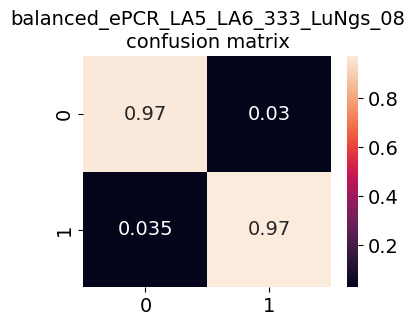

In [9]:
def plot_confusion_matrix(
    df: pd.DataFrame,
    title: str = "",
    output_filename: str = None,
    fs = 14,
    ):

    cm = confusion_matrix(df[f'XGB_prediction_1'], y_test['label'])
    cm_norm = cm / cm.sum(axis=0)
    plt.figure(figsize=(4, 3))
    ax = sns.heatmap(cm_norm, annot=cm_norm, annot_kws={"size": fs});
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=fs)

    title_handle = plt.title(title, fontsize=fs)    

    if output_filename is not None:
        if not output_filename.endswith(".png"):
            output_filename += ".png"
        plt.savefig(
            output_filename,
            facecolor="w",
            dpi=300,
            bbox_inches="tight",
            bbox_extra_artists=[title_handle],
        )

    return

output_cm_plot = os.path.join(params['workdir'], f"{params['out_basename']}confusion_matrix")
plot_confusion_matrix(df, title=f"{params['data_name']}\nconfusion matrix", output_filename=output_cm_plot)

print(f'{report_name} size {X_test[cls_features].shape}, f1: {accuracy_score(df["XGB_prediction_1"], y_test["label"])}')


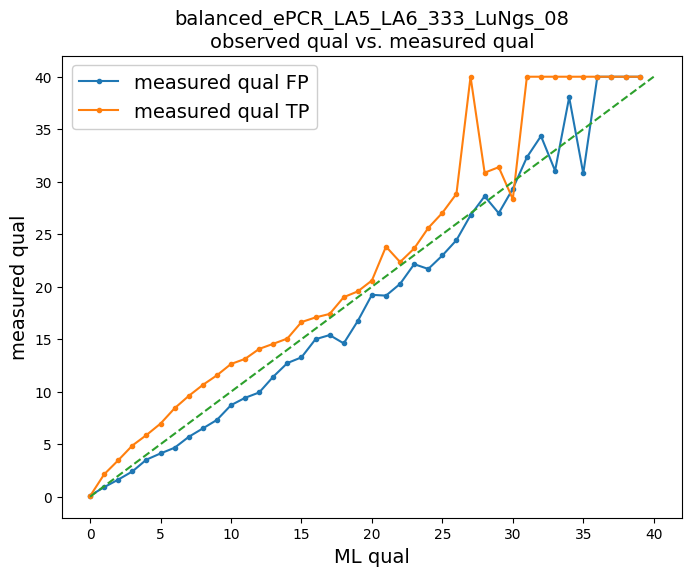

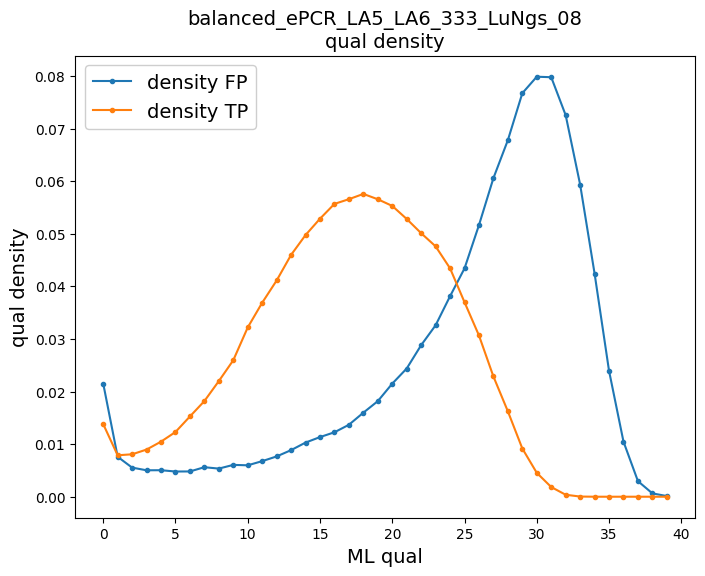

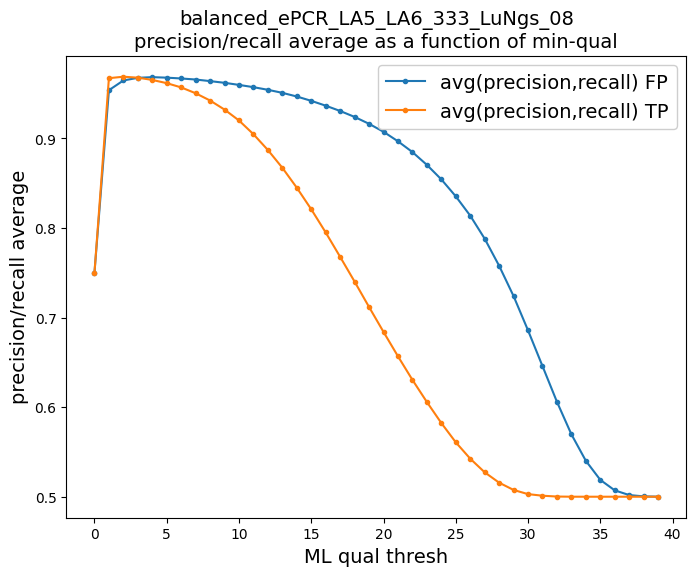

In [10]:
def plot_observed_vs_measured_qual(
    labels_dict,
    fprs,
    max_score,
    title: str = "",
    output_filename: str = None,
    fs = 14,
    ):

    plt.figure(figsize=(8,6))    
    for label in labels_dict:
        plot_precision_recall(fprs[label], 
                            [f'measured qual {labels_dict[label]}'], 
                            log_scale=False,
                            max_score=max_score)
    plt.plot([0,max_score], [0, max_score],'--')
    plt.xlabel('ML qual',fontsize=fs)
    plt.ylabel('measured qual',fontsize=fs)
    legend_handle = plt.legend(fontsize=fs, fancybox=True, framealpha=0.95)
    title_handle = plt.title(title, fontsize=fs)    

    if output_filename is not None:
        if not output_filename.endswith(".png"):
            output_filename += ".png"
        plt.savefig(
            output_filename,
            facecolor="w",
            dpi=300,
            bbox_inches="tight",
            bbox_extra_artists=[title_handle, legend_handle],
        )

    return

output_obsereved_qual_plot = os.path.join(params['workdir'], f"{params['out_basename']}observed_qual")
plot_observed_vs_measured_qual(labels_dict,fprs,max_score, title=f"{params['data_name']}\nobserved qual vs. measured qual", output_filename=output_obsereved_qual_plot)


def plot_qual_density(
    labels_dict,
    recalls,
    max_score,
    title: str = "",
    output_filename: str = None,
    fs = 14,
    ):

    plt.figure(figsize=(8,6))

    for label in labels_dict:
        plot_precision_recall(recalls[label], 
                            [f'density {labels_dict[label]}'],
                            log_scale=False,
                            max_score=max_score)

    legend_handle = plt.legend(fontsize=fs, fancybox=True, framealpha=0.95)
    title_handle = plt.title(title, fontsize=fs)    
    plt.xlabel('ML qual',fontsize=fs)
    plt.ylabel('qual density',fontsize=fs)

    if output_filename is not None:
        if not output_filename.endswith(".png"):
            output_filename += ".png"
        plt.savefig(
            output_filename,
            facecolor="w",
            dpi=300,
            bbox_inches="tight",
            bbox_extra_artists=[title_handle, legend_handle],
        )

    return

output_qual_density = os.path.join(params['workdir'], f"{params['out_basename']}qual_density")
plot_qual_density(labels_dict,recalls,max_score, title=f"{params['data_name']}\nqual density", output_filename=output_qual_density)


def plot_precision_recall_vs_qual_thresh(
    df,
    labels_dict,    
    max_score,
    title: str = "",
    output_filename: str = None,
    fs = 14,
    ):
    plt.figure(figsize=(8,6))
    plt.title('precision/recall average as a function of min-qual')
    for label in labels_dict:
        cum_avg_precision_recalls = []
        gtr = df['label'] == label
        cum_fprs_, cum_recalls_ = precision_recall_curve(df[f'XGB_qual_{label}'], 
                                                        max_score=max_score, 
                                                        y_true=gtr, 
                                                        cumulative=True, 
                                                        apply_log_trans=False
                                                        )
        cum_avg_precision_recalls.append([(precision+recall)/2 for precision,recall in zip(cum_fprs_, cum_recalls_)])

        plot_precision_recall(cum_avg_precision_recalls, 
                            [f'avg(precision,recall) {labels_dict[label]}'], 
                            log_scale=False,
                            max_score=max_score)

    legend_handle = plt.legend(fontsize=fs, fancybox=True, framealpha=0.95)
    title_handle = plt.title(title, fontsize=fs)    
    plt.xlabel('ML qual thresh',fontsize=fs)
    plt.ylabel('precision/recall average',fontsize=fs)

    if output_filename is not None:
        if not output_filename.endswith(".png"):
            output_filename += ".png"
        plt.savefig(
            output_filename,
            facecolor="w",
            dpi=300,
            bbox_inches="tight",
            bbox_extra_artists=[title_handle, legend_handle],
        )
    return

output_precision_recall_qual = os.path.join(params['workdir'], f"{params['out_basename']}precision_recall_qual")
plot_precision_recall_vs_qual_thresh(df,labels_dict,max_score, title=f"{params['data_name']}\nprecision/recall average as a function of min-qual", output_filename=output_precision_recall_qual)


# Model qual metrics: hists by class, calibration, recalls vs qual

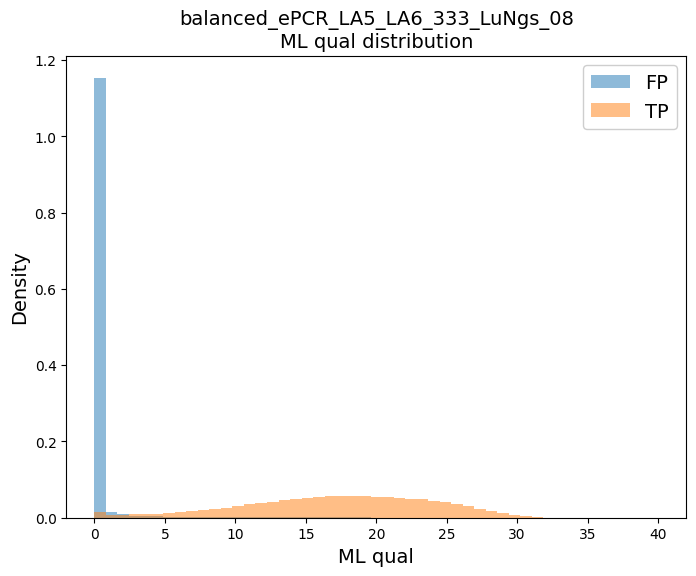

In [11]:
def plot_ML_qual_hist(
    labels_dict,
    df,
    max_score,
    title: str = "",
    output_filename: str = None,
    fs = 14,
    ):

    score = f'XGB_qual_1'

    plt.figure(figsize=[8, 6])
    plt.title("xgb")
    bins = np.linspace(0, max_score, 50)
    for label in labels_dict:    
        plt.hist(
            df[df["label"] == label][score].clip(
                upper=max_score
            ),
            bins=bins,
            alpha=0.5,
            label=labels_dict[label],
            density=True,
        )

    plt.xlabel('ML qual',fontsize=fs)
    plt.ylabel('Density',fontsize=fs)
    legend_handle = plt.legend(fontsize=fs, fancybox=True, framealpha=0.95)
    title_handle = plt.title(title, fontsize=fs)    

    if output_filename is not None:
        if not output_filename.endswith(".png"):
            output_filename += ".png"
        plt.savefig(
            output_filename,
            facecolor="w",
            dpi=300,
            bbox_inches="tight",
            bbox_extra_artists=[title_handle, legend_handle],
        )

    return

output_ML_qual_hist = os.path.join(params['workdir'], f"{params['out_basename']}ML_qual_hist")
plot_ML_qual_hist(labels_dict,df,max_score, title=f"{params['data_name']}\nML qual distribution", output_filename=output_ML_qual_hist)


# features distribution by classes

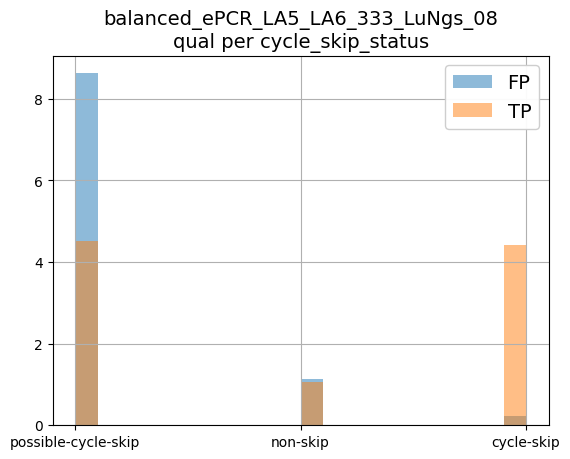

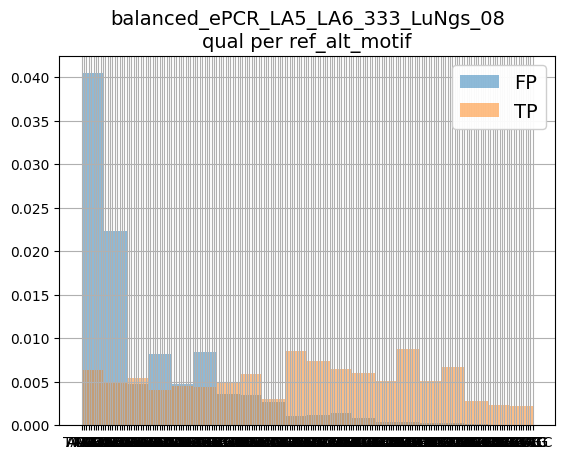

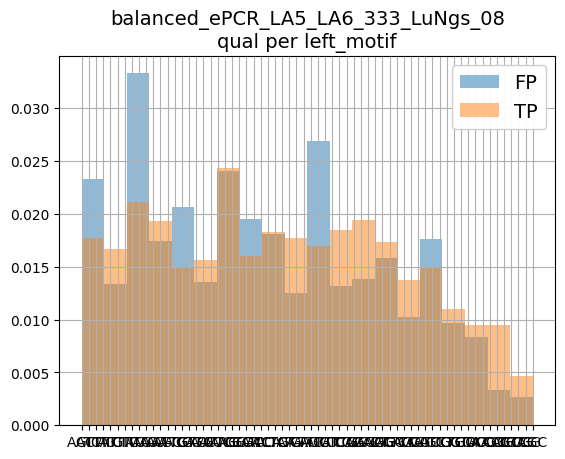

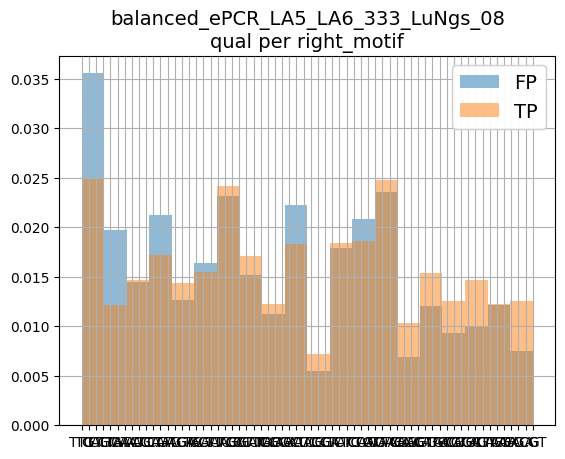

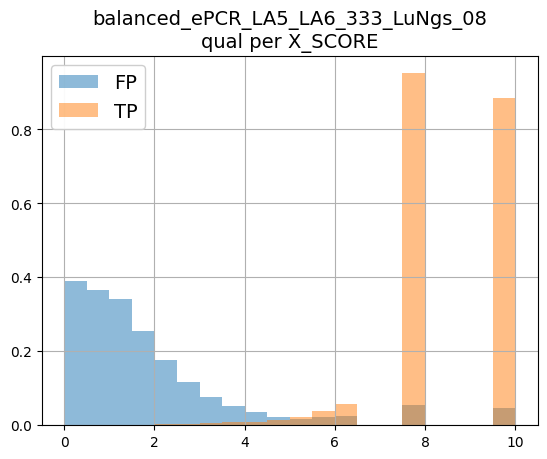

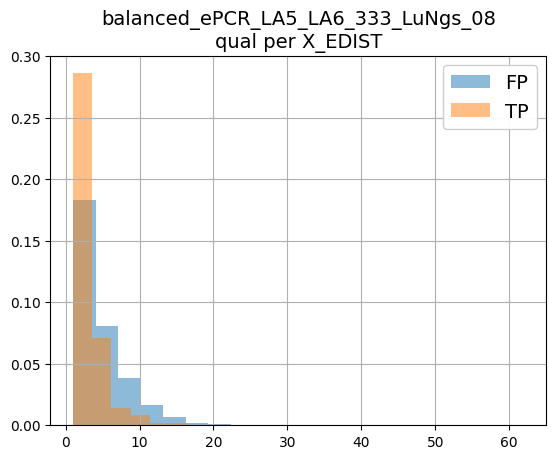

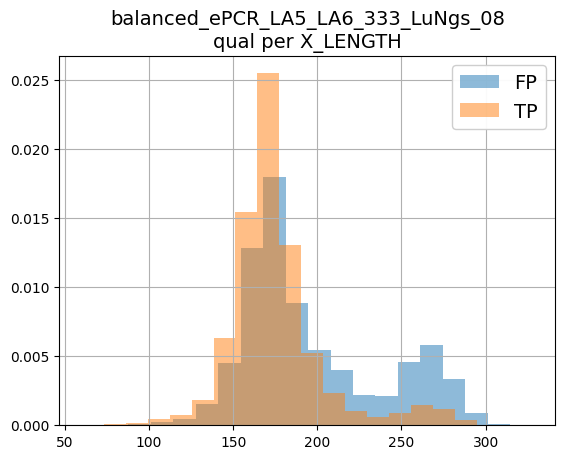

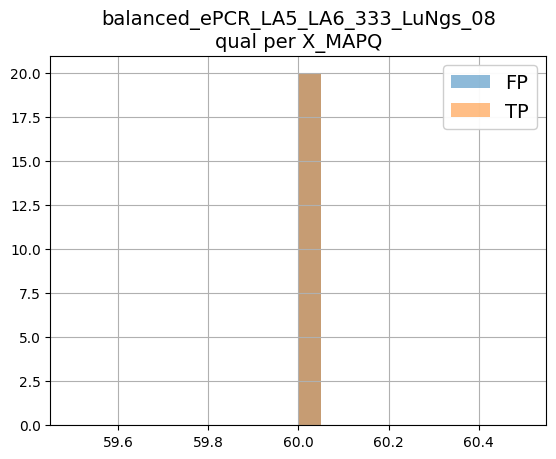

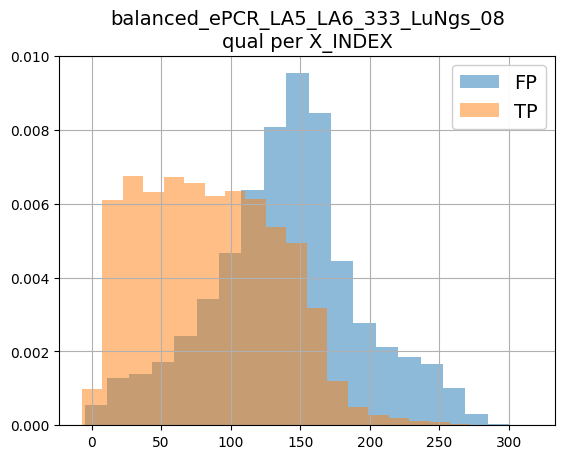

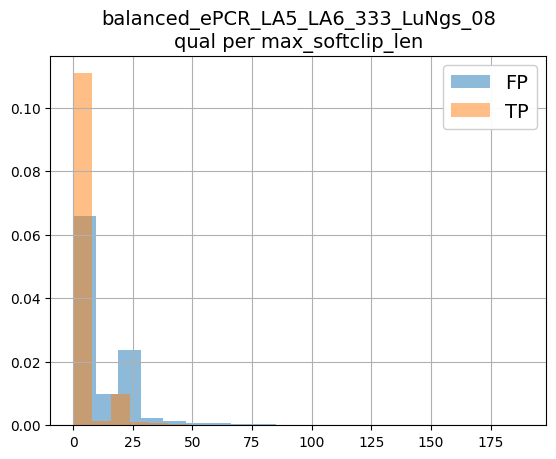

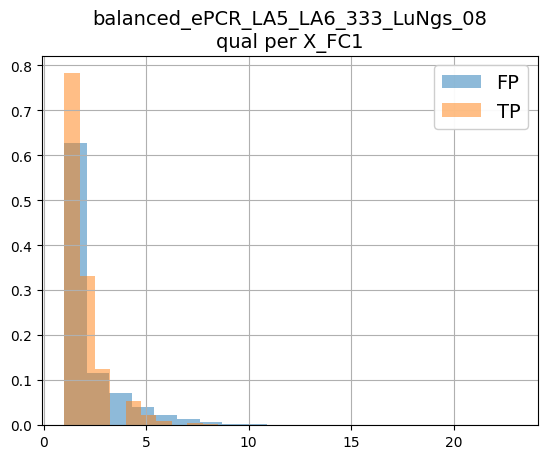

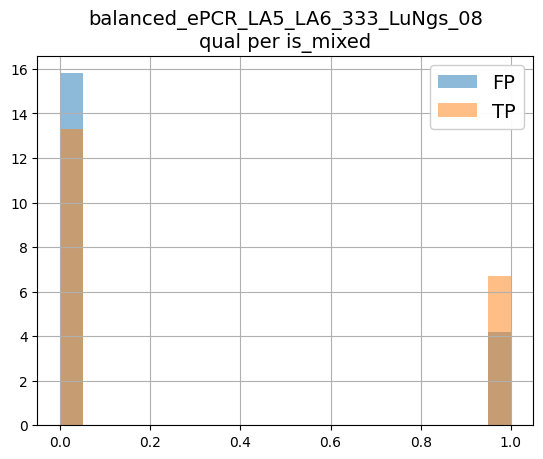

In [12]:
def plot_qual_per_feature(
    labels_dict,
    df,
    max_score,
    title: str = "",
    output_filename: str = None,
    fs = 14,
    ):

    features = cls_features
    if 'is_mixed' in df:
        df['is_mixed'] = df['is_mixed'].astype(int)
    for feature in features:
        plt.figure()
        for label in labels_dict:
            _ = df[df['label']==label][feature].hist(bins=20, alpha=0.5, label=labels_dict[label], density=True)
        legend_handle = plt.legend(fontsize=fs, fancybox=True, framealpha=0.95)
        feature_title = title + feature
        title_handle = plt.title(feature_title, fontsize=fs)    
        output_filename_feature = output_filename+feature
        if output_filename_feature is not None:
            if not output_filename_feature.endswith(".png"):
                output_filename_feature += ".png"
        plt.savefig(
            output_filename_feature,
            facecolor="w",
            dpi=300,
            bbox_inches="tight",
            bbox_extra_artists=[title_handle, legend_handle],
        )

    return

output_qual_per_feature = os.path.join(params['workdir'], f"{params['out_basename']}qual_per_")
plot_qual_per_feature(labels_dict,df,max_score, title=f"{params['data_name']}\nqual per ", output_filename=output_qual_per_feature)

# qual hist by classes, separated by read and variant type: mixed and cycle skip combinations

mixed & cs : Mean ML_QUAL: 24.20, Median ML_QUAL: 24.69
mixed & ~cs : Mean ML_QUAL: 9.52, Median ML_QUAL: 0.18
~mixed & cs : Mean ML_QUAL: 15.77, Median ML_QUAL: 16.43
~mixed & ~cs : Mean ML_QUAL: 4.66, Median ML_QUAL: 0.02


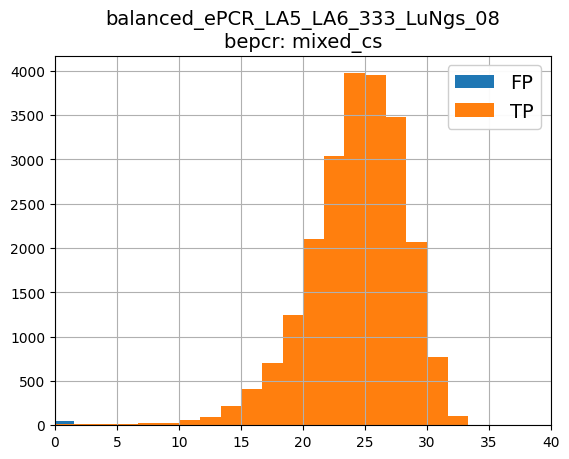

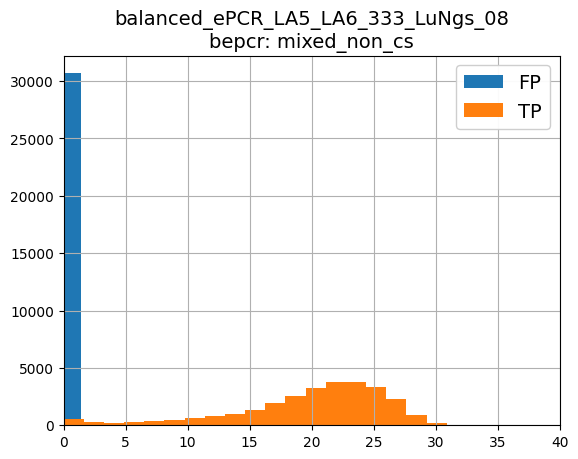

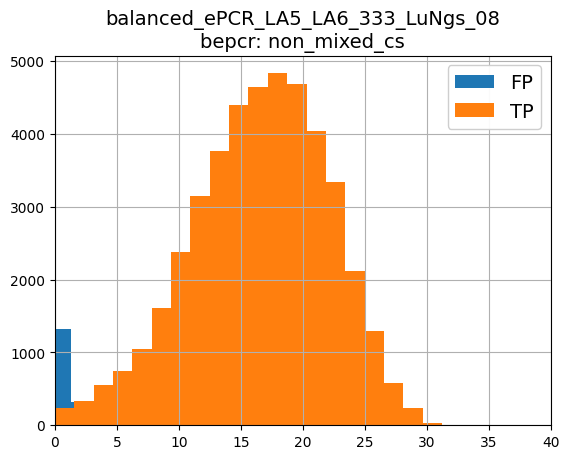

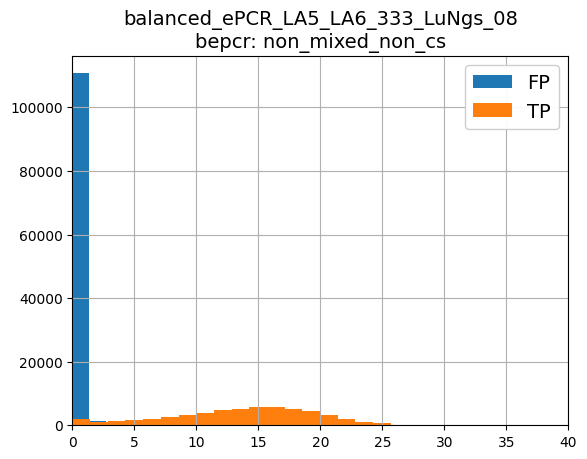

In [8]:
def get_mixed_data(df):
    df_mixed_cs = df[(df['is_mixed']) & (df['cycle_skip_status']=='cycle-skip')]
    df_mixed_non_cs = df[(df['is_mixed']) & (df['cycle_skip_status']!='cycle-skip')]
    df_non_mixed_non_cs = df[(~df['is_mixed']) & (df['cycle_skip_status']!='cycle-skip')]
    df_non_mixed_cs = df[(~df['is_mixed']) & (df['cycle_skip_status']=='cycle-skip')]            
    return df_mixed_cs, df_mixed_non_cs, df_non_mixed_non_cs, df_non_mixed_cs

def get_fpr_recalls_mixed(
        df_mixed_cs,
        df_mixed_non_cs,
        df_non_mixed_cs,
        df_non_mixed_non_cs
    ):
    score = f'XGB_qual_1'
    label = 1
    gtr = df_mixed_cs['label'] == label
    fprs_mixed_cs, recalls_mixed_cs = precision_recall_curve(df_mixed_cs[score], max_score=max_score, y_true=gtr)
    gtr = df_mixed_non_cs['label'] == label
    fprs_mixed_non_cs, recalls_mixed_non_cs = precision_recall_curve(df_mixed_non_cs[score], max_score=max_score, y_true=gtr)
    gtr = df_non_mixed_cs['label'] == label
    fprs_non_mixed_cs, recalls_non_mixed_cs = precision_recall_curve(df_non_mixed_cs[score], max_score=max_score, y_true=gtr)
    gtr = df_non_mixed_non_cs['label'] == label
    fprs_non_mixed_non_cs, recalls_non_mixed_non_cs = precision_recall_curve(df_non_mixed_non_cs[score], max_score=max_score, y_true=gtr)

    return fprs_mixed_cs, recalls_mixed_cs, fprs_mixed_non_cs, recalls_mixed_non_cs, fprs_non_mixed_cs, recalls_non_mixed_cs, fprs_non_mixed_non_cs, recalls_non_mixed_non_cs
def plot_mixed(
    labels_dict,
    df_mixed_cs, 
    df_mixed_non_cs, 
    df_non_mixed_non_cs, 
    df_non_mixed_cs,
    max_score,
    title: str = "",
    output_filename: str = None,
    fs = 14,
    ):

    score = f'XGB_qual_1'

    for td, name in zip([df_mixed_cs, df_mixed_non_cs, df_non_mixed_cs, df_non_mixed_non_cs], 
        ['mixed & cs', 'mixed & ~cs', '~mixed & cs', '~mixed & ~cs']):
        # Mean and median ML_QUAL in [mixed/non-mixed]*[cskp/non-cskp]
        print(name, ': Mean ML_QUAL: {:.2f}, Median ML_QUAL: {:.2f}'.format(td[score].mean(),td[score].median()))
        
    for td, name in zip([df_mixed_cs, df_mixed_non_cs, df_non_mixed_cs, df_non_mixed_non_cs], 
        ['mixed_cs', 'mixed_non_cs', 'non_mixed_cs', 'non_mixed_non_cs']):
        plt.figure()
        plt.title(title+name)
        for label in labels_dict:
            _ = td[td['label']==label][score].clip(upper=max_score).hist(bins=20, label=labels_dict[label])
        # plt.ylim([0, 120000])
        plt.xlim([0,max_score])
        legend_handle = plt.legend(fontsize=fs, fancybox=True, framealpha=0.95)
        feature_title = title + name
        title_handle = plt.title(feature_title, fontsize=fs)    
        output_filename_feature = output_filename+name
        if output_filename_feature is not None:
            if not output_filename_feature.endswith(".png"):
                output_filename_feature += ".png"
        plt.savefig(
            output_filename_feature,
            facecolor="w",
            dpi=300,
            bbox_inches="tight",
            bbox_extra_artists=[title_handle, legend_handle],
        )

    return


if 'is_mixed' in df:
    df_mixed_cs, df_mixed_non_cs, df_non_mixed_non_cs, df_non_mixed_cs = get_mixed_data(df)
    (fprs_mixed_cs, recalls_mixed_cs, fprs_mixed_non_cs, recalls_mixed_non_cs, 
    fprs_non_mixed_cs, recalls_non_mixed_cs, fprs_non_mixed_non_cs, recalls_non_mixed_non_cs) = get_fpr_recalls_mixed(df_mixed_cs, df_mixed_non_cs, df_non_mixed_cs, df_non_mixed_non_cs)

    output_bepcr_hists = os.path.join(params['workdir'], f"{params['out_basename']}bepcr_")
    plot_mixed(labels_dict, df_mixed_cs, df_mixed_non_cs, df_non_mixed_non_cs, df_non_mixed_cs, max_score, title=f"{params['data_name']}\nbepcr: ", output_filename=output_bepcr_hists)

# false positive rate, recalls vs qual

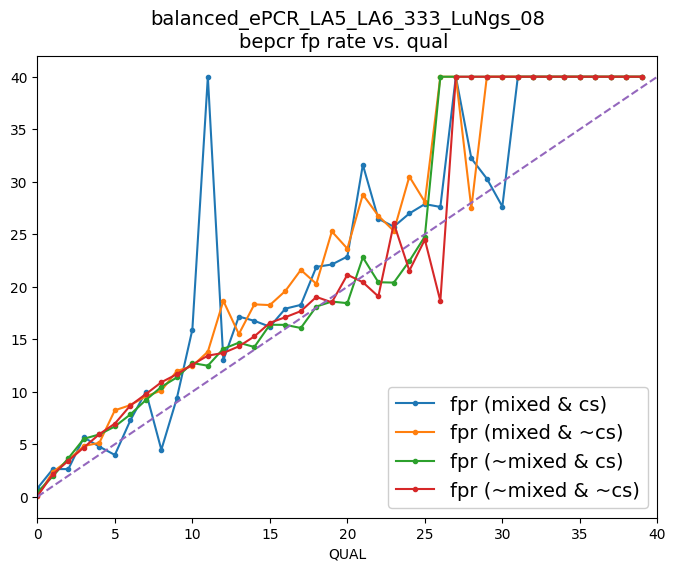

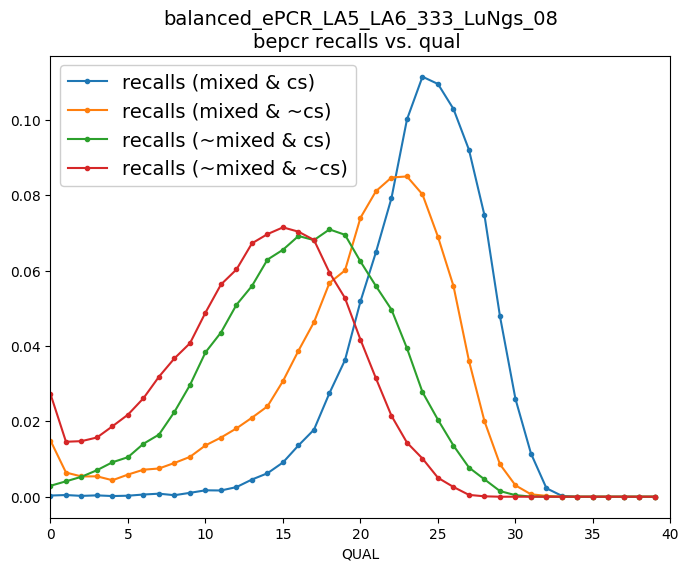

In [12]:


def plot_mixed_fpr(    
    fprs_mixed_cs, 
    fprs_mixed_non_cs, 
    fprs_non_mixed_cs, 
    fprs_non_mixed_non_cs,
    max_score,
    title: str = "",
    output_filename: str = None,
    fs = 14,
    ):

    plt.figure(figsize=(8,6))
    plot_precision_recall([fprs_mixed_cs, fprs_mixed_non_cs, fprs_non_mixed_cs, fprs_non_mixed_non_cs], 
                            ['fpr (mixed & cs)', 'fpr (mixed & ~cs)', 'fpr (~mixed & cs)', 'fpr (~mixed & ~cs)'], 
                            log_scale=False,
                            max_score=max_score)
    plt.plot([0,40], [0,40],'--')
    plt.xlim([0,max_score])
    legend_handle = plt.legend(fontsize=fs, fancybox=True, framealpha=0.95)
    title_handle = plt.title(title, fontsize=fs)    
    if output_filename is not None:
        if not output_filename.endswith(".png"):
            output_filename += ".png"
    plt.savefig(
        output_filename,
        facecolor="w",
        dpi=300,
        bbox_inches="tight",
        bbox_extra_artists=[title_handle, legend_handle],
    )

    return

output_bepcr_fpr = os.path.join(params['workdir'], f"{params['out_basename']}bepcr_fpr")
plot_mixed_fpr(fprs_mixed_cs, fprs_mixed_non_cs, fprs_non_mixed_cs, fprs_non_mixed_non_cs, max_score, title=f"{params['data_name']}\nbepcr fp rate vs. qual ", output_filename=output_bepcr_fpr)

def plot_mixed_recall(
    recalls_mixed_cs, 
    recalls_mixed_non_cs, 
    recalls_non_mixed_cs, 
    recalls_non_mixed_non_cs,
    max_score,
    title: str = "",
    output_filename: str = None,
    fs = 14,
    ):

    plt.figure(figsize=(8,6))
    plot_precision_recall([recalls_mixed_cs, recalls_mixed_non_cs, recalls_non_mixed_cs, recalls_non_mixed_non_cs], 
                          ['recalls (mixed & cs)', 'recalls (mixed & ~cs)', 'recalls (~mixed & cs)', 'recalls (~mixed & ~cs)'], 
                            log_scale=False, max_score=max_score)

    plt.xlim([0,max_score])
    legend_handle = plt.legend(fontsize=fs, fancybox=True, framealpha=0.95)
    title_handle = plt.title(title, fontsize=fs)    
    if output_filename is not None:
        if not output_filename.endswith(".png"):
            output_filename += ".png"
    plt.savefig(
        output_filename,
        facecolor="w",
        dpi=300,
        bbox_inches="tight",
        bbox_extra_artists=[title_handle, legend_handle],
    )

    return

output_bepcr_recalls = os.path.join(params['workdir'], f"{params['out_basename']}bepcr_recalls")
plot_mixed_recall(recalls_mixed_cs, recalls_mixed_non_cs, recalls_non_mixed_cs, recalls_non_mixed_non_cs, max_score, title=f"{params['data_name']}\nbepcr recalls vs. qual ", output_filename=output_bepcr_recalls)
